# Compute the waveform similarity and plot the traces

This notebook plots the repeated events caused by the same gouge patch associated with the fb03-087.

2024.02.11 Kurama Okubo

2024.10.31 update for the merged catalog.

<!-- **NOTE:** This notebook is needed to dump the `gridsearch_bestparam_M0andTR_fb03-087_withCC_fromAS{}.csv`, which includes the maximum correlation function to threshold out the events for the evaluation of moment-duration scaling. -->

In [53]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

from multiprocessing import Pool, cpu_count
from obspy.signal.cross_correlation import correlate, xcorr_max

from itertools import combinations

from scipy.spatial.distance import euclidean, correlation

%load_ext autoreload
%autoreload 2

from AEevents_Gridsearch_PS_func import *
from AEevents_plot_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# rootdir for removal resp analysis
rootdir = "./"

# Event location
eventloc_table = "../data/datacsv/AE_obs_location.csv"

# output datadir
data_inputdir = "../data/07_DATA_MTinversion"

# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# select balldrop calibration model
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

if balldrop_model==4:
    aperturecorrection=True
elif balldrop_model==2:
    aperturecorrection=False
else:
    aperturecorrection=False
    
# Path for event location table
datadir = f"../data/06_assemble_gf_model{balldrop_model}"

# Path to the best fit source parameters
bestfitsourceparam_finame = "../data/datacsv/gridsearch_bestparam_M0andTR_fb03-087.csv"


In [55]:
figdir = "../figure/09_repeatedevents"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [56]:
# read event loc
df_eventloc = pd.read_csv(eventloc_table, index_col=0)
df_eventloc["Z"] = 0
df_eventloc["datacase"] = df_eventloc.apply(lambda row: "{}__{:04d}".format(row.exprID, row.name), axis=1)
datacases = df_eventloc["datacase"].values
df_eventloc

,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best,Z,datacase
gougeevent_id,,,,,,,,,,,
4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0000,-0.0002,0,fb03-087__0004
9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0000,0.0000,0,fb03-087__0009
18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0000,0.0000,0,fb03-087__0018
19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0000,0.0000,0,fb03-087__0019
20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0000,0.0010,0,fb03-087__0020
21,10,fb03-087,63.752300,1.7470,0.00425,6200,3600,0.0000,0.0000,0,fb03-087__0021
24,11,fb03-087,66.186944,1.7420,0.00425,6200,3600,0.0000,0.0000,0,fb03-087__0024
27,14,fb03-087,76.018478,1.7460,0.00245,6200,3600,0.0000,0.0002,0,fb03-087__0027
30,15,fb03-087,79.319850,1.7505,0.01000,6200,3600,0.0000,0.0000,0,fb03-087__0030


In [57]:
# load best parameters
df_bestparam = pd.read_csv(bestfitsourceparam_finame, index_col=0)
df_bestparam.head()

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.89,0.57,3.3,0
fb03-087__0009,0.73,0.05,3.1,0
fb03-087__0018,0.87,0.61,3.5,0
fb03-087__0019,0.79,0.05,3.1,0
fb03-087__0020,0.89,0.77,3.3,0


In [58]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# 3. Plot repeated event

Select the station and plot the traces to show the repeated events at same gouge patch.

In [59]:
repeated_sensor = "OL23"

st_repeat = Stream()

for datacase in datacases:
# datacase = datacases[4] # We repeated running the notebook with selecting the datacase to complete the grid search for all the events.
    print(f"start processing {repeated_sensor} event {datacase}.")

    # load event trace
    st_event = read(datadir + "/{}_AEwaveform.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance
    
    # load parameter file
    with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacase, balldrop_model),"rb") as fo:
        param = pickle.load(fo)
        
    # param['df_dist_sorted'].pop("OL06") # remove the farthest sensor due to low coherence

    # load best parameters
    M0_best = df_bestparam[df_bestparam.index==datacase]["M0_best"][0]
    TR_best = df_bestparam[df_bestparam.index==datacase]["TR_best"][0]
    rake_best = df_bestparam[df_bestparam.index==datacase]["rake_best"][0]
    M0hat_best = M0_best*np.sqrt(2) # Note: this is used to synthesize the best fit traces
    # Compute synthesized waveform with best parameters
    # st_event_trimmed = get_retrimmed_traces(M0hat_best, rake_best, TR_best*1e-6, param)
    param["aperturecorrection"] = True # DEBUG: This should be stored in the pickle file
    st_event_trimmed = get_retrimmed_traces(M0hat_best, rake_best, TR_best*1e-6, param, fix_dtshift=False, aperturecorrection=param["aperturecorrection"])
    
    # Compute synthesized waveform with best parameters
    st_event_trimmed = get_retrimmed_traces(M0_best, rake_best, TR_best*1e-6, param)

    f"{datacase.split('__')[0]}: event {datacase.split('__')[1]:s}"

    tr_obs_filt = st_event_trimmed.select(location="Filt", channel="OZ", station=repeated_sensor)[0]
    tr_syn_p_filt_shifted = st_event_trimmed.select(location="FiltShifted_P", channel="VZ", station=repeated_sensor)[0]
    
    tr_obs_P = st_event_trimmed.select(location="Retrim_P", channel="OZ", station=repeated_sensor)[0]
    tr_syn_P = st_event_trimmed.select(location="Retrim_P", channel="VZ", station=repeated_sensor)[0]
    
    st_repeat.append(tr_obs_filt)
    st_repeat.append(tr_syn_p_filt_shifted)
    st_repeat.append(tr_obs_P)
    st_repeat.append(tr_syn_P)

start processing OL23 event fb03-087__0004.
aperture correct: OL07 incident angle=68.142134deg. beta_p=0.642768
aperture correct: OL08 incident angle=75.745726deg. beta_p=0.615206
aperture correct: OL23 incident angle=55.269486deg. beta_p=0.711522
aperture correct: OL22 incident angle=76.176812deg. beta_p=0.613972
start processing OL23 event fb03-087__0009.
aperture correct: OL07 incident angle=66.854879deg. beta_p=0.608690
aperture correct: OL08 incident angle=75.706994deg. beta_p=0.572624
aperture correct: OL23 incident angle=56.720919deg. beta_p=0.667917
aperture correct: OL22 incident angle=76.209598deg. beta_p=0.571062
start processing OL23 event fb03-087__0018.
aperture correct: OL07 incident angle=67.359469deg. beta_p=0.680738
aperture correct: OL08 incident angle=75.459415deg. beta_p=0.653006
aperture correct: OL23 incident angle=56.147263deg. beta_p=0.735537
aperture correct: OL22 incident angle=76.407803deg. beta_p=0.650500
start processing OL23 event fb03-087__0019.
aperture

# Compute the stack of observed trace and normalized correlation coefficient
To quantify the variation of events, we compute the stack of the observed trace within the trimmed time window and compute the correlation coefficient to each event trace.

~~To avoid the small variation in arrival time, we shift the trace to the reference event before stacking.~~

We found the time shift is less than 0.1us in P as below. We thus ignore the time shift and just stack all the trace.
We do not normalize the amplitude for the stack, which indicates the larger events are more weighted.

In [60]:
# 1. stacked trace
st_obs_all = st_repeat.select(location="Filt", channel="OZ").copy()
st_obs_all_P = st_repeat.select(location="Retrim_P", channel="OZ").copy()
tr_stack = st_obs_all[0].copy()
tr_stack.data=np.zeros(tr_stack.stats.npts)
ref_obs_P = st_obs_all_P[0]
max_lag_shift = 30
for i, tr_P in enumerate(st_obs_all_P):

    gougeevent_id = int(datacases[i].split("__")[1])
    cc = correlate(ref_obs_P.taper(0.1), tr_P.taper(0.1), max_lag_shift, demean=True, normalize='naive') # the order is 1.ref and 2. cur
    N_shift, _ = xcorr_max(cc,  abs_max=False)
    # print(cc[0], N_shift)
    dt_shift = N_shift * tr_P.stats.delta # [s] time to shift for the correction of arrival
    print(f"Time shift of event {gougeevent_id} to reference: {dt_shift*1e6:.2f} us")
    
# plt.plot(ref_obs_P.data)
# plt.plot(tr_P.data)

Time shift of event 4 to reference: 0.00 us
Time shift of event 9 to reference: 0.00 us
Time shift of event 18 to reference: -0.10 us
Time shift of event 19 to reference: 0.10 us
Time shift of event 20 to reference: 0.00 us
Time shift of event 21 to reference: 0.10 us
Time shift of event 24 to reference: 0.10 us
Time shift of event 27 to reference: -0.10 us
Time shift of event 30 to reference: 0.00 us
Time shift of event 31 to reference: 0.10 us
Time shift of event 37 to reference: -0.20 us
Time shift of event 38 to reference: 0.20 us
Time shift of event 40 to reference: 0.20 us
Time shift of event 43 to reference: 0.00 us
Time shift of event 44 to reference: 0.00 us
Time shift of event 49 to reference: 0.20 us
Time shift of event 50 to reference: -0.10 us
Time shift of event 52 to reference: 0.00 us
Time shift of event 55 to reference: -0.10 us
Time shift of event 59 to reference: -0.20 us
Time shift of event 61 to reference: -0.10 us
Time shift of event 62 to reference: 0.00 us
Time 

In [61]:
# linear stack
# NOTE: do not normalize the amplitude so that the larger events are weighted, which shows a good S/N.
tr_stack = st_obs_all.copy().stack(group_by='all', stack_type='linear')[0]
tr_stack

FB.OL23.Filt.OZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.000310000Z | 10000000.0 Hz, 3101 samples

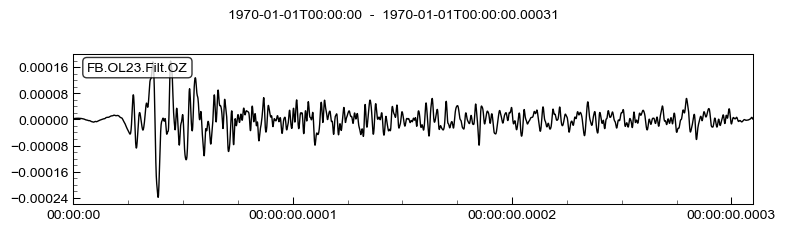

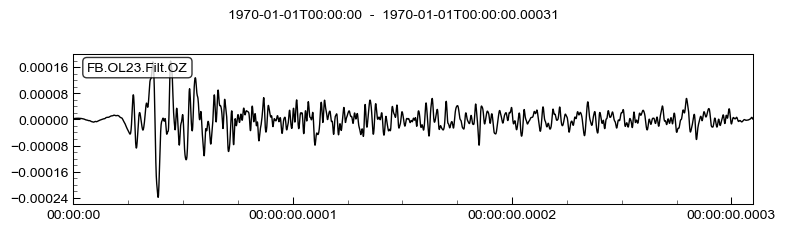

In [62]:
tr_stack.plot()

## Compute correlation coefficient

We use obspy `correlate` with normalization.

In [63]:
# trim the trace with the time
tmax=0.12*1e3 #[us]

st_obs_trimmed_all = Stream()

for tr in st_obs_all:
    tr_trim = tr.copy()
    tstart = tr_trim.stats.starttime
    tend = UTCDateTime(tstart.year, tstart.month, tstart.day, tstart.hour, tstart.minute, tstart.second, int(tstart.microsecond+tmax), precision=8)
    tr_trim.trim(tstart, tend)
    st_obs_trimmed_all.append(tr_trim)

In [64]:
# # trim the stacked trace
tr_stack_trimmed = tr_stack.copy()
tstart = tr_stack_trimmed.stats.starttime
tend = UTCDateTime(tstart.year, tstart.month, tstart.day, tstart.hour, tstart.minute, tstart.second, int(tstart.microsecond+tmax), precision=6) # stacked trace has precision of 6
tr_stack_trimmed.trim(tstart, tend)

FB.OL23.Filt.OZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.000120000Z | 10000000.0 Hz, 1201 samples

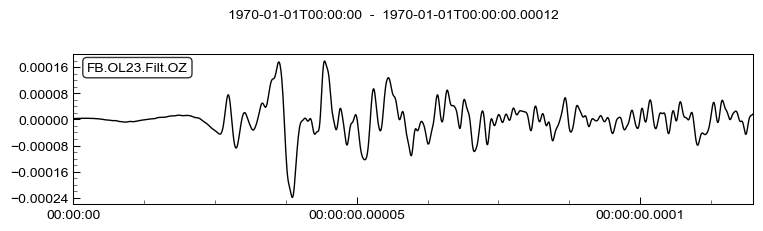

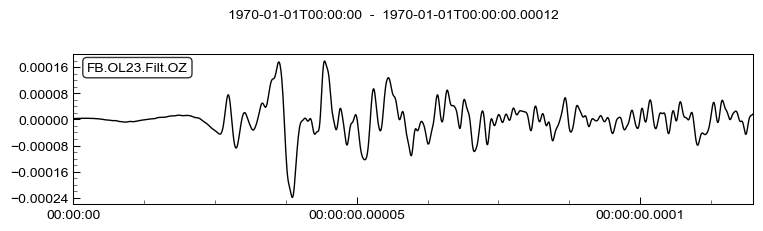

In [65]:
tr_stack_trimmed.plot()

In [66]:
# Compute correlation of the entire trace between the stacked and individual traces and get max cc
df_bestparam_withcc = df_bestparam.copy()

max_lag_shift_stack = int(0.01e-3 * tr_stack_trimmed.stats.sampling_rate) # allow for +-10us shift 

max_cc_all = []
for i, tr_obs_trimmed in enumerate(st_obs_trimmed_all):

    gougeevent_id = int(datacases[i].split("__")[1])
    cc = correlate(tr_stack_trimmed.taper(0.05), tr_obs_trimmed.taper(0.05), max_lag_shift_stack, demean=True, normalize='naive') # the order is 1.ref and 2. cur
    N_shift, max_cc = xcorr_max(cc,  abs_max=False)
    dt_shift = N_shift * tr_stack_trimmed.stats.delta # [s] time to shift for the correction of arrival
    max_cc_all.append(max_cc)
    print(f"Time shift of event {gougeevent_id} to reference: {dt_shift*1e6:.2f} us max_cc={max_cc}")
    df_bestparam_withcc.loc[datacases[i], "max_cc"] = max_cc


Time shift of event 4 to reference: 0.00 us max_cc=0.8943824461019967
Time shift of event 9 to reference: 0.60 us max_cc=0.6882178214406262
Time shift of event 18 to reference: 0.10 us max_cc=0.7932590717220809
Time shift of event 19 to reference: 0.60 us max_cc=0.7108426241689748
Time shift of event 20 to reference: 0.20 us max_cc=0.8510632385284983
Time shift of event 21 to reference: 0.90 us max_cc=0.7084385211225196
Time shift of event 24 to reference: 0.40 us max_cc=0.6748874675949971
Time shift of event 27 to reference: 0.00 us max_cc=0.8816650364929847
Time shift of event 30 to reference: 1.00 us max_cc=0.5989457127584746
Time shift of event 31 to reference: -0.20 us max_cc=0.6798391655751992
Time shift of event 37 to reference: 2.50 us max_cc=0.38756845625218733
Time shift of event 38 to reference: -0.20 us max_cc=0.5327999757096953
Time shift of event 40 to reference: 0.10 us max_cc=0.3298362717705478
Time shift of event 43 to reference: 0.40 us max_cc=0.8093849843062617
Time 

In [67]:
df_bestparam_withcc.head()

,VR_P_best,M0_best,TR_best,rake_best,max_cc
fb03-087__0004,0.89,0.57,3.3,0,0.894382
fb03-087__0009,0.73,0.05,3.1,0,0.688218
fb03-087__0018,0.87,0.61,3.5,0,0.793259
fb03-087__0019,0.79,0.05,3.1,0,0.710843
fb03-087__0020,0.89,0.77,3.3,0,0.851063


In [68]:
df_bestparam_withcc.to_csv("../data/datacsv/gridsearch_bestparam_M0andTR_fb03-087_withCC_fromAS{}.csv".format(repeated_sensor[2:]))

## Threshold out with the correlation coefficient

We threshold out the event with low cc.

In [69]:
cc_thresh = 0.6
cc_thresh_inds = np.where(np.array(max_cc_all)>cc_thresh)[0]
datacases_thresh = datacases[cc_thresh_inds]
max_cc_thresh = np.array(max_cc_all)[cc_thresh_inds]
# len(datacases)

In [70]:
len(cc_thresh_inds)

28

In [71]:
# compute stats for source distance
dist_all = []
for tr in st_repeat.select(location="Filt", channel="OZ"):
    dist_all.append(tr.stats.dist)

dist = np.mean(dist_all)

freqmin = param['freqmin']
freqmax = param['freqmax']

In [72]:
cc_thresh_inds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 13, 14, 15, 17, 19, 20, 21, 23,
       26, 29, 30, 31, 32, 33, 35, 37, 39, 41, 42])

fb03-087__0004
fb03-087__0009
fb03-087__0018
fb03-087__0019
fb03-087__0020
fb03-087__0021
fb03-087__0024
fb03-087__0027
fb03-087__0031
fb03-087__0043
fb03-087__0044
fb03-087__0049
fb03-087__0052
fb03-087__0059
fb03-087__0061
fb03-087__0062
fb03-087__0072
fb03-087__0077
fb03-087__0088
fb03-087__0089
fb03-087__0095
fb03-087__0099
fb03-087__0100
fb03-087__0109
fb03-087__0111
fb03-087__0120
fb03-087__0128
fb03-087__0129


/Users/kokubo/opt/miniconda3/envs/obspy3.8/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


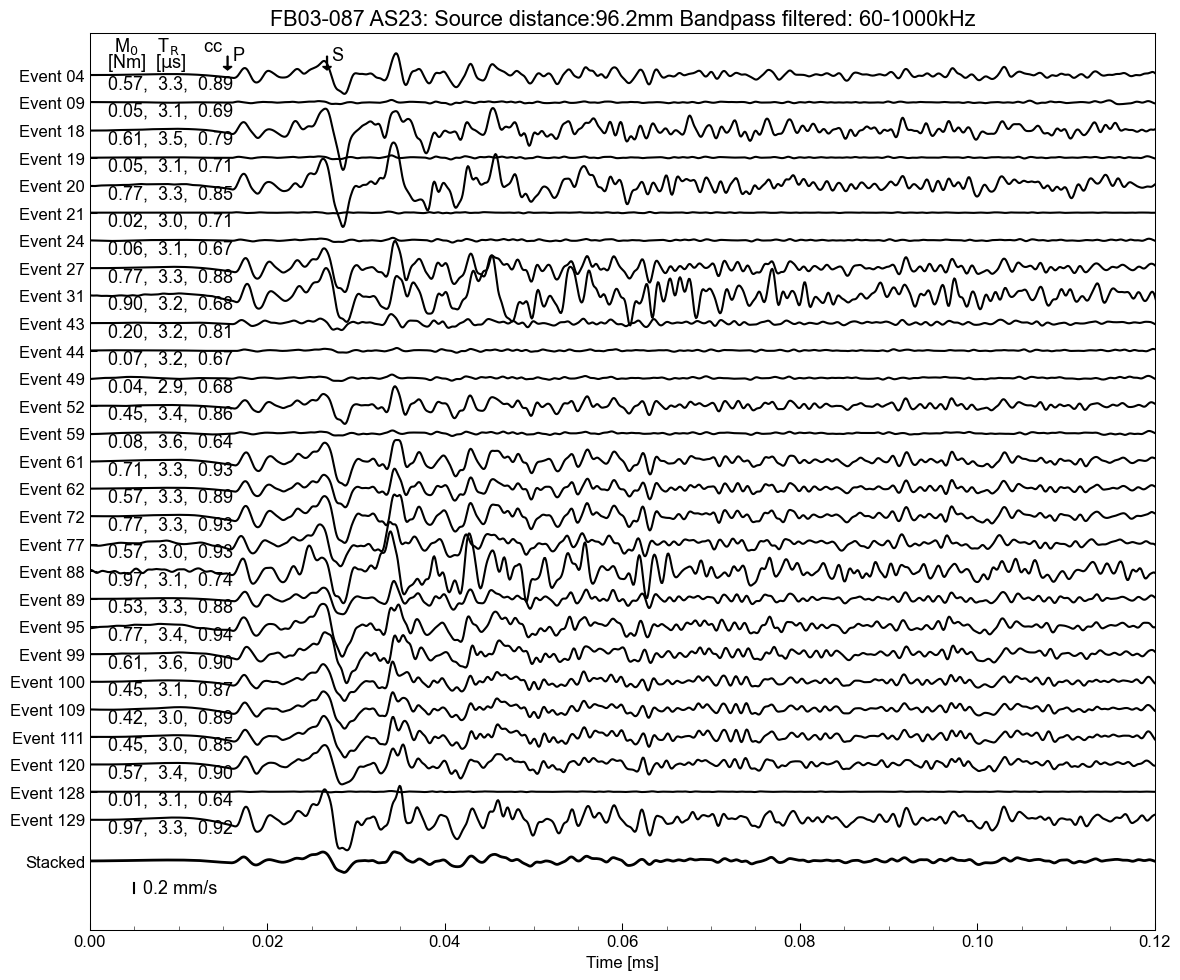

In [73]:
# Plot repeated traces
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

plt.rcParams["font.size"] = 13

selected_sensor = st_repeat[0].stats.station
tvec = st_repeat[0].times()*1e3

# compute P and S arrival
tp = dist/param['cp']
ts = dist/param['cs']

yshift = 0
del_yshift = 4e-3
ampnorm = 0.14 #12
yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_repeat[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

# Plot repeated events
for i, datacase in enumerate(datacases_thresh):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])

    tr_obs = st_repeat.select(location="Filt", channel="OZ")[cc_thresh_inds[i]]
    tr_syn = st_repeat.select(location="FiltShifted_P", channel="VZ")[cc_thresh_inds[i]]
    assert(tr_obs.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    dt_shift_p = tr_syn.stats.dt_shift * 1e3
    ytickloc.append(-yshift)
    yticklabel.append(f"Event {gougeevent_id:02d}")
    ax.plot(tvec-pretrigger, (tr_obs.data/ampnorm) - yshift, "k-")
    # ax.plot(tvec-pretrigger+dt_shift_p, (tr_syn.data/ampnorm) - yshift - yspan, "r-", lw=1)
    yshift = yshift + del_yshift

    
# Annotate estimated source parameters
annot_x = 0.0027
annot_x_text = 0.002
annot_y = -0.0019

for i, datacase in enumerate(datacases_thresh):
    print(datacase)
    M0_best = df_bestparam_withcc.loc[datacase]["M0_best"]
    TR_best = df_bestparam_withcc.loc[datacase]["TR_best"]
    cc_tmp = df_bestparam_withcc.loc[datacase]["max_cc"]
    ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f},  {:.2f}".format(M0_best, TR_best, cc_tmp), ha="left")
    
annot_txt = ["M$_{\mathrm{0}}$", "T$_{\mathrm{R}}$", "cc"]
annot_txt_unit = ["[Nm]", "[$\mathrm{\mu}$s]", ""]
ax.text(annot_x, ytickloc[0]+3.4e-3, "{}    {}     {}   ".format(*annot_txt), ha="left")
ax.text(annot_x-0.0008, ytickloc[0]+1.2e-3, "{}  {}     {}   ".format(*annot_txt_unit), ha="left")


# annotate the scale of velocity
scale_x = 0.005
scale_y = -(np.min(ytickloc)-0.01)
scale_amplitude = 0.2e-3 #[mm/s]
ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-");
ax.text(scale_x+0.001, -(scale_amplitude/2/ampnorm)-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )

# annotate p and s arrival
arrow_y = 2.7e-3
ax.arrow(tp, arrow_y, 0, -2e-3, width=1e-4, length_includes_head=True, head_length=5e-4,head_width=1e-3, color='k')
ax.arrow(ts, arrow_y, 0, -2e-3, width=1e-4, length_includes_head=True, head_length=5e-4,head_width=1e-3, color='k')
ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
ax.text(ts, arrow_y-0.6e-3, " S", ha="left")

# plot stacked trace
yshift = yshift + 0.5*del_yshift
ax.plot(tvec-pretrigger, (tr_stack.data/ampnorm) - yshift, "k-", lw=2)
ytickloc.append(-yshift)
yticklabel.append("Stacked")


# decoration of figure
ax.set_xlim([0.0, 0.12])
ax.set_ylim([np.min(ytickloc)-0.01, 0.006])

ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel)

title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e3:.0f}-{freqmax/1e3:.0f}kHz"

ax.set_title(title_str)


fig.tight_layout()

plt.savefig(figdir + "/waveform_repeated_event_{}.png".format(repeated_sensor), dpi=300)
plt.savefig(figdir + "/waveform_repeated_event_{}.eps".format(repeated_sensor))


In [74]:
ytickloc

[0,
 -0.004,
 -0.008,
 -0.012,
 -0.016,
 -0.02,
 -0.024,
 -0.028,
 -0.032,
 -0.036000000000000004,
 -0.04000000000000001,
 -0.04400000000000001,
 -0.048000000000000015,
 -0.05200000000000002,
 -0.05600000000000002,
 -0.060000000000000026,
 -0.06400000000000003,
 -0.06800000000000003,
 -0.07200000000000004,
 -0.07600000000000004,
 -0.08000000000000004,
 -0.08400000000000005,
 -0.08800000000000005,
 -0.09200000000000005,
 -0.09600000000000006,
 -0.10000000000000006,
 -0.10400000000000006,
 -0.10800000000000007,
 -0.11400000000000007]

In [75]:
df_bestparam

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.89,0.57,3.3,0
fb03-087__0009,0.73,0.05,3.1,0
fb03-087__0018,0.87,0.61,3.5,0
fb03-087__0019,0.79,0.05,3.1,0
fb03-087__0020,0.89,0.77,3.3,0
fb03-087__0021,0.88,0.02,3.0,0
fb03-087__0024,0.84,0.06,3.1,0
fb03-087__0027,0.91,0.77,3.3,0
fb03-087__0030,0.59,0.06,3.3,0
fb03-087__0031,0.90,0.90,3.2,0


In [76]:
tr_obs = st_repeat.select(channel="OZ")[0]
print(f"max amp:{tr_obs.data.max()*1e3} mm/s")

max amp:0.43761432467282213 mm/s


## Plot all traces without the cc threshold

fb03-087__0004
fb03-087__0009
fb03-087__0018
fb03-087__0019
fb03-087__0020
fb03-087__0021
fb03-087__0024
fb03-087__0027
fb03-087__0030
fb03-087__0031
fb03-087__0037
fb03-087__0038
fb03-087__0040
fb03-087__0043
fb03-087__0044
fb03-087__0049
fb03-087__0050
fb03-087__0052
fb03-087__0055
fb03-087__0059
fb03-087__0061
fb03-087__0062
fb03-087__0069
fb03-087__0072
fb03-087__0075
fb03-087__0076
fb03-087__0077
fb03-087__0081
fb03-087__0085
fb03-087__0088
fb03-087__0089
fb03-087__0095
fb03-087__0099
fb03-087__0100
fb03-087__0102
fb03-087__0109
fb03-087__0110
fb03-087__0111
fb03-087__0118
fb03-087__0120
fb03-087__0126
fb03-087__0128
fb03-087__0129
fb03-087__0131


/Users/kokubo/opt/miniconda3/envs/obspy3.8/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


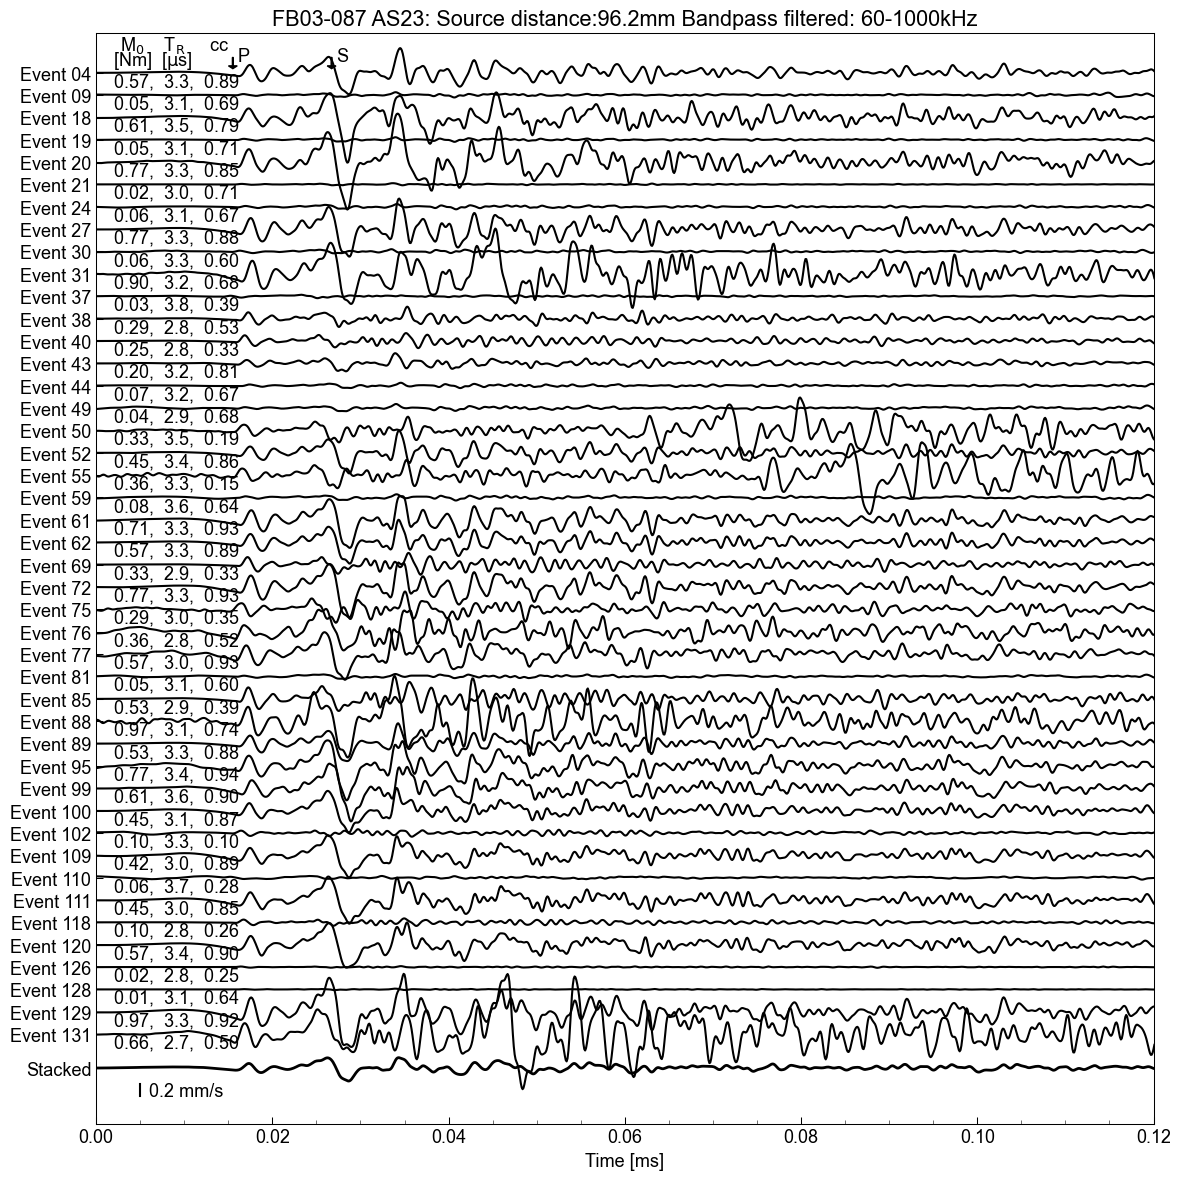

In [77]:
# Plot repeated traces
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

plt.rcParams["font.size"] = 13

selected_sensor = st_repeat[0].stats.station
tvec = st_repeat[0].times()*1e3

# compute P and S arrival
tp = dist/param['cp']
ts = dist/param['cs']

yshift = 0
del_yshift = 4e-3
ampnorm = 0.1 #0.14 #12
yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_repeat[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

# Plot repeated events
for i, datacase in enumerate(datacases):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])

    tr_obs = st_repeat.select(location="Filt", channel="OZ")[i]
    tr_syn = st_repeat.select(location="FiltShifted_P", channel="VZ")[i]
    assert(tr_obs.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    dt_shift_p = tr_syn.stats.dt_shift * 1e3
    ytickloc.append(-yshift)
    yticklabel.append(f"Event {gougeevent_id:02d}")
    ax.plot(tvec-pretrigger, (tr_obs.data/ampnorm) - yshift, "k-")
    # ax.plot(tvec-pretrigger+dt_shift_p, (tr_syn.data/ampnorm) - yshift - yspan, "r-", lw=1)
    yshift = yshift + del_yshift

    
# Annotate estimated source parameters
annot_x = 0.0027
annot_x_text = 0.002
annot_y = -0.0024

for i, datacase in enumerate(datacases):
    print(datacase)
    M0_best = df_bestparam.loc[datacase]["M0_best"]
    TR_best = df_bestparam.loc[datacase]["TR_best"]
    ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f},  {:.2f}".format(M0_best, TR_best, max_cc_all[i]), ha="left")
    
annot_txt = ["M$_{\mathrm{0}}$", "T$_{\mathrm{R}}$", "cc"]
annot_txt_unit = ["[Nm]", "[$\mathrm{\mu}$s]", ""]
ax.text(annot_x, ytickloc[0]+4.0e-3, "{}    {}     {}   ".format(*annot_txt), ha="left")
ax.text(annot_x-0.0008, ytickloc[0]+1.4e-3, "{}  {}     {}   ".format(*annot_txt_unit), ha="left")


# annotate the scale of velocity
scale_x = 0.005
scale_y =  -(np.min(ytickloc)-0.01) #0.185 #0.117
scale_amplitude = 0.2e-3 #[mm/s]
ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-");
ax.text(scale_x+0.001, -(scale_amplitude/2/ampnorm)-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )

# annotate p and s arrival
arrow_y = 2.7e-3
ax.arrow(tp, arrow_y, 0, -2e-3, width=1e-4, length_includes_head=True, head_length=5e-4,head_width=1e-3, color='k')
ax.arrow(ts, arrow_y, 0, -2e-3, width=1e-4, length_includes_head=True, head_length=5e-4,head_width=1e-3, color='k')
ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
ax.text(ts, arrow_y-0.6e-3, " S", ha="left")

# plot stacked trace
yshift = yshift + 0.5*del_yshift
ax.plot(tvec-pretrigger, (tr_stack.data/ampnorm) - yshift, "k-", lw=2)
ytickloc.append(-yshift)
yticklabel.append("Stacked")


# decoration of figure
ax.set_xlim([0.0, 0.12])
ax.set_ylim([np.min(ytickloc)-0.01, 0.007])

ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel)

title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e3:.0f}-{freqmax/1e3:.0f}kHz"

ax.set_title(title_str)


fig.tight_layout()

plt.savefig(figdir + "/waveform_repeated_event_{}_noccthreshold.png".format(repeated_sensor), dpi=300)
plt.savefig(figdir + "/waveform_repeated_event_{}_noccthreshold.eps".format(repeated_sensor))


In [78]:
# ytickloc

This is the end of notebook. We analyze the statistics of the source paramters next.